In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
import scipy.stats as ss
import pickle
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as mtr
from xgboost import XGBClassifier

In [8]:
pd.options.display.max_rows = 150
pd.options.display.max_columns = 100

In [9]:
feat = pd.read_pickle('./datasets/soft/gen/feat.pkl')

In [10]:
X_df = feat.drop('Dismissed', axis=1).copy()
cat_cols = ['PrevBonusBiggerMean', 'WageBiggerPosGeoMean', 'WageBiggerPosStrMean', 'LangPosBiggerMode', 'PosPerBiggerMean', 'CustTimeBiggerMean', 'ProjPerBiggerMean', 
            '3MonthsUtilBiggerMean', 'IsIntProjNow', 'IsIntProjLastPos', 'IsHalfVac', 'IsYearVac', 'IsQuartOnSite', 'IsTop5Pos', 'WasTrainee',
            'DevCenterID', 'SBUID', 'PositionID', 'CompetenceGroupID', 'FunctionalOfficeID', 'PaymentTypeId']
num_cols = [col for col in X_df.columns.values if col not in cat_cols]

In [11]:
df = X_df

for col in cat_cols:
    _, uniqs = pd.factorize(df[col])
    print(f'Unique values for {col}: {uniqs}')

Unique values for PrevBonusBiggerMean: Int64Index([0, 1], dtype='int64')
Unique values for WageBiggerPosGeoMean: Int64Index([0, 1], dtype='int64')
Unique values for WageBiggerPosStrMean: Int64Index([0, 1], dtype='int64')
Unique values for LangPosBiggerMode: Int64Index([0, 1], dtype='int64')
Unique values for PosPerBiggerMean: Int64Index([0, 1], dtype='int64')
Unique values for CustTimeBiggerMean: Int64Index([1, 0], dtype='int64')
Unique values for ProjPerBiggerMean: Int64Index([0, 1], dtype='int64')
Unique values for 3MonthsUtilBiggerMean: Int64Index([1, 0], dtype='int64')
Unique values for IsIntProjNow: Int64Index([0, 1], dtype='int64')
Unique values for IsIntProjLastPos: Int64Index([0, 1], dtype='int64')
Unique values for IsHalfVac: Int64Index([1, 0], dtype='int64')
Unique values for IsYearVac: Int64Index([1, 0], dtype='int64')
Unique values for IsQuartOnSite: Int64Index([0, 1], dtype='int64')
Unique values for IsTop5Pos: Int64Index([0, 1], dtype='int64')
Unique values for WasTrainee

In [12]:
corr_mat = X_df[num_cols].corr()

# sns.set(rc = {'figure.figsize':(30,30)})
# sns.heatmap(corr_mat, annot=True, cmap='Reds')
# plt.show()

In [13]:
corr_thr = 0.7

tril_mat = corr_mat.copy().to_numpy()
triu_idx = np.triu_indices(tril_mat.shape[0])
tril_mat[triu_idx] = 0
corr_idx = np.column_stack(np.where(tril_mat >= corr_thr))
corr_info = list()
for r, c in corr_idx:
    corr_val = corr_mat.iat[r, c]
    corr_info.append((corr_mat.index[r], corr_mat.columns[c], corr_val))
corr_info = pd.DataFrame(corr_info, columns = ["f1", "f2", "pearson"])
corr_info = corr_info.sort_values(by=["f1"], ascending=False, axis=0)

display(corr_info)

hcorr_num_feat = corr_info['f2']

,f1,f2,pearson
0,YearWageRate,HalfWageRate,0.838800
25,YearVacRate,HalfVacRate,0.825904
18,YearUtilRate,HalfUtilRate,0.965033
15,YearProjRate,HalfProjRate,0.815081
8,YearPosRate,HalfPosRate,0.708332
28,YearOnSiteRate,HalfOnSiteRate,0.985987
2,WageRate,YearWageRate,0.921237
1,WageRate,HalfWageRate,0.791729
4,WageProjPosDiff,WagePosGeoDiff,0.709278
3,WagePosLangQuant,WagePosQuant,0.842482


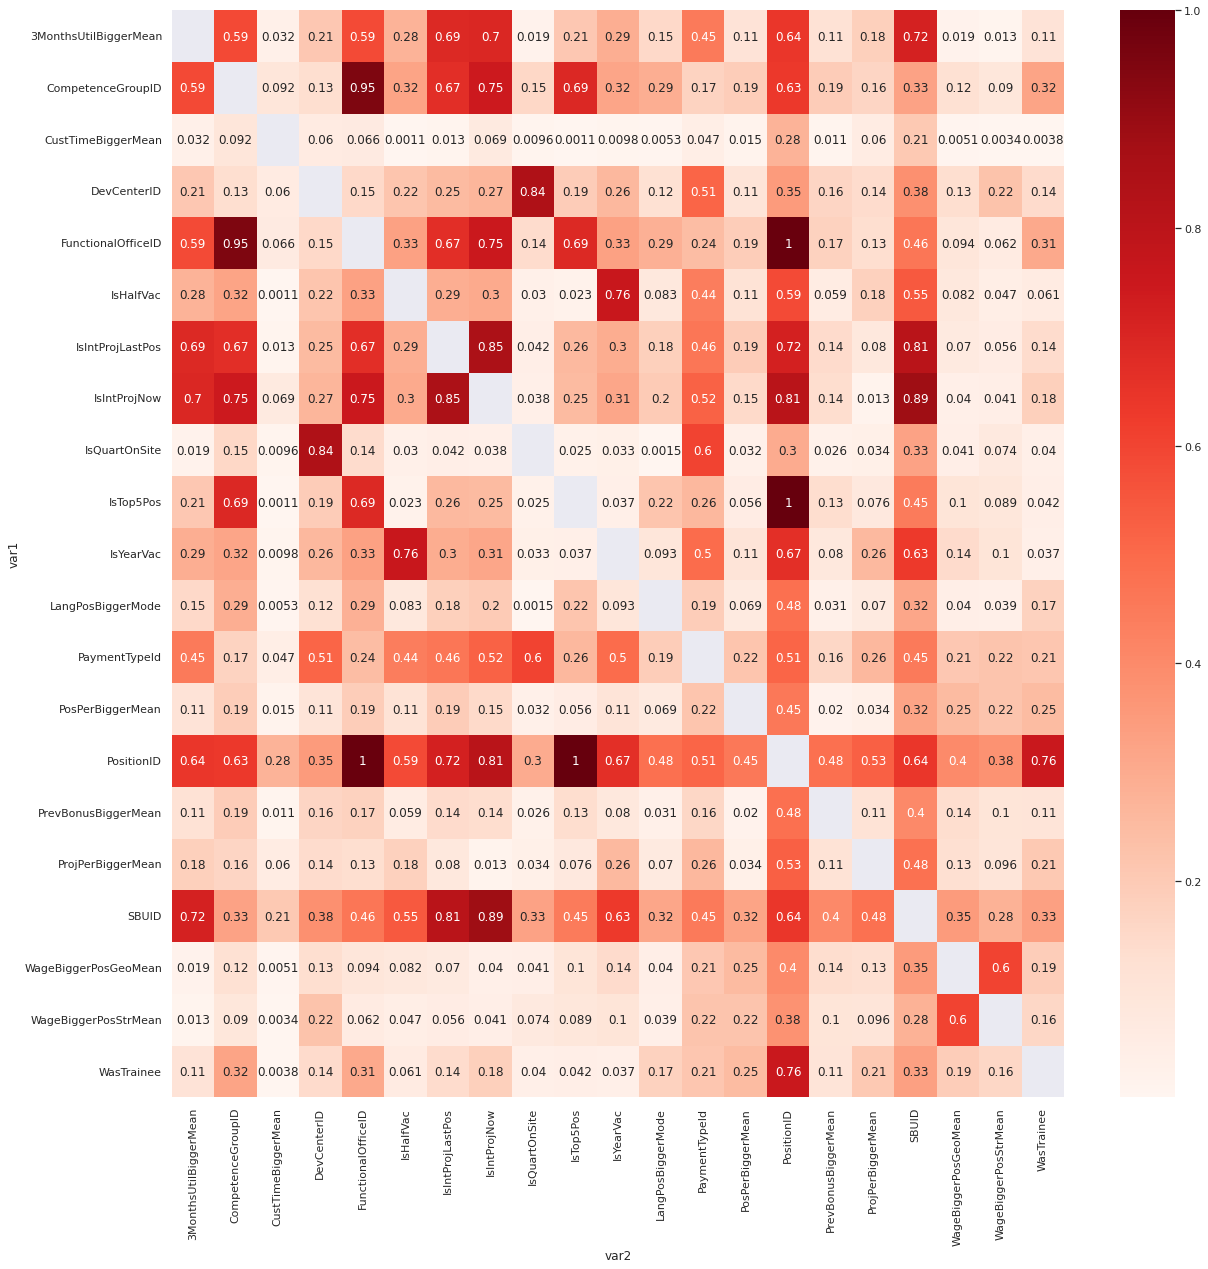

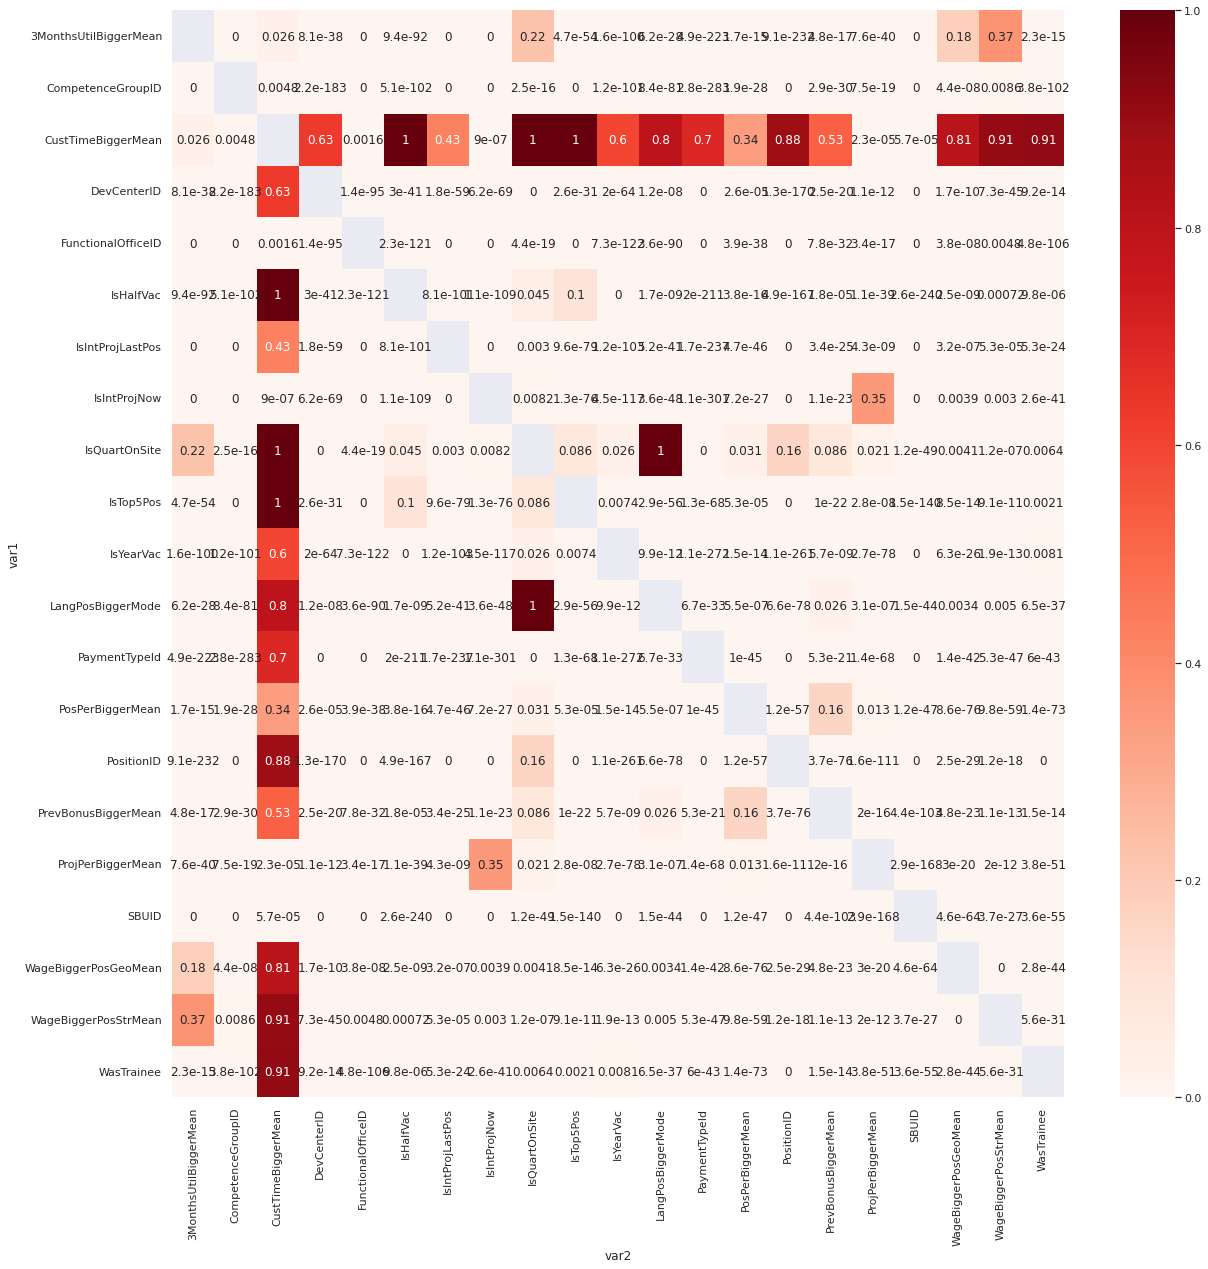

In [14]:
df = X_df
cat_prod = list(product(cat_cols, cat_cols, repeat=1))

chi_res = []
cram_res = []
for i in cat_prod:
    if i[0] != i[1]:
        chi_res.append((i[0], i[1],
                      list(ss.chi2_contingency(pd.crosstab(df[i[0]], df[i[1]])))[1]))
        cram_res.append((i[0], i[1],
                        ss.contingency.association(pd.crosstab(df[i[0]], df[i[1]]))))

chi_df = pd.DataFrame(chi_res, columns = ["var1", "var2", "coeff"])
cram_df = pd.DataFrame(cram_res, columns = ["var1", "var2", "coeff"])
chi_df = chi_df.pivot(index = "var1", columns = "var2", values = "coeff")
cram_df = cram_df.pivot(index = "var1", columns = "var2", values = "coeff")

sns.set(rc = {'figure.figsize':(20,20)})
sns.heatmap(cram_df, annot = True, cmap = 'Reds')
plt.show()
sns.heatmap(chi_df, annot = True, cmap = 'Reds')
plt.show()

In [15]:
assoc_mat = cram_df
sign_mat = chi_df

assoc_thr = 0.7
sign_thr = 0.05

tril_mat = assoc_mat.copy().to_numpy()
triu_idx = np.triu_indices(tril_mat.shape[0])
tril_mat[triu_idx] = 0
assoc_idx = np.column_stack(np.where(tril_mat >= assoc_thr))
assoc_info = list()
for r, c in assoc_idx:
    sign_val = sign_mat.iat[r, c]
    assoc_val = assoc_mat.iat[r, c]
    if sign_val <= sign_thr:
        assoc_info.append((assoc_mat.index[r], assoc_mat.columns[c], assoc_val, sign_val))
assoc_info = pd.DataFrame(assoc_info, columns = ["f1", "f2", "cramer", "p_val"])
assoc_info = assoc_info.sort_values(by=["f1"], ascending=False, axis=0)

display(assoc_info)

hcorr_cat_feat = pd.Series(['SBUID', 'PositionID', 'IsYearVac', 'CompetenceGroupID', 'IsQuartOnSite'])

,f1,f2,cramer,p_val
13,WasTrainee,PositionID,0.757853,0.0
10,SBUID,3MonthsUtilBiggerMean,0.716838,0.0
11,SBUID,IsIntProjLastPos,0.805845,0.0
12,SBUID,IsIntProjNow,0.886684,0.0
6,PositionID,FunctionalOfficeID,0.995105,0.0
7,PositionID,IsIntProjLastPos,0.722946,0.0
8,PositionID,IsIntProjNow,0.805778,0.0
9,PositionID,IsTop5Pos,1.000000,0.0
5,IsYearVac,IsHalfVac,0.760031,0.0
4,IsQuartOnSite,DevCenterID,0.843192,0.0


In [16]:
lcorr_feat = feat.drop(np.append(hcorr_cat_feat, hcorr_num_feat), axis=1)
print((feat.shape[1] - lcorr_feat.shape[1]) / feat.shape[1])

0.30927835051546393


In [17]:
oh_feat = lcorr_feat.copy()
lcorr_cols = [col for col in cat_cols if col not in hcorr_cat_feat.values]
oh_df = pd.get_dummies(data=oh_feat[lcorr_cols], columns=lcorr_cols)#, prefix=lcorr_cols, prefix_sep='_')
oh_feat = oh_feat.drop(lcorr_cols, axis=1)
oh_feat = pd.concat([oh_df, oh_feat], axis=1)

In [18]:
def split_cv_folds(df):
    # df = df.sample(frac=1)

    no_dism_df = df[df['Dismissed'] == 0]
    dism_df = df[df['Dismissed'] == 1]

    no_dism_idx = np.arange(0, no_dism_df.shape[0], no_dism_df.shape[0]//10)
    no_dism_idx[10] = no_dism_df.shape[0]
    dism_idx = np.arange(0, dism_df.shape[0], dism_df.shape[0]//10)
    dism_idx[10] = dism_df.shape[0]

    cv_folds = {}
    prev_idx = (no_dism_idx[0], dism_idx[0])
    for num, cur_idx in enumerate(zip(no_dism_idx[1:], dism_idx[1:])):
        cv_folds[num] = pd.concat([no_dism_df.iloc[prev_idx[0]:cur_idx[0]], dism_df.iloc[prev_idx[1]:cur_idx[1]]],
                               axis=0)
        prev_idx = cur_idx
    return cv_folds

def calc_metrics(preds, y_test):
    cfm = mtr.confusion_matrix(y_test, preds)
    prec = cfm[1][1] / (cfm[0][1] + cfm[1][1])
    rec = cfm[1][1] / (cfm[1][0] + cfm[1][1])
    f1 = 2 * (prec * rec) / (prec + rec)
    return prec, rec, f1

def get_cv_metrics_imps(cv_folds):
    runs_metrics = []
    feat_importances = []
    feat_names = None
    for i in range(10):
        train_folds = {key:df for key, df in cv_folds.items() if key != i}
        train_df = pd.concat(train_folds, axis=0)
        X_train = train_df.drop('Dismissed', axis=1)
        y_train = train_df['Dismissed']
        test_df = cv_folds[i]
        X_test = test_df.drop('Dismissed', axis=1)
        y_test = test_df['Dismissed']
        
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        runs_metrics.append(calc_metrics(preds, y_test))
        
        feat_names = X_train.columns.tolist()
        feat_importances.append(model.feature_importances_)
    runs_metrics = pd.DataFrame(runs_metrics, columns=['Prec', 'Rec', 'F1'])
    feat_importances = pd.DataFrame(feat_importances, columns=feat_names)
    return runs_metrics, feat_importances

In [19]:
df = oh_feat
cv_folds = split_cv_folds(df)
cv_metrics, imps = get_cv_metrics_imps(cv_folds)
display(cv_metrics)
display(imps)

,Prec,Rec,F1
0,0.936508,0.584158,0.719512
1,0.955882,0.643564,0.769231
2,0.955224,0.633663,0.761905
3,0.945946,0.693069,0.800000
4,0.971429,0.673267,0.795322
5,0.935897,0.722772,0.815642
6,0.905405,0.663366,0.765714
7,0.898734,0.702970,0.788889
8,0.947368,0.712871,0.813559
9,0.961039,0.685185,0.800000


,PrevBonusBiggerMean_0,PrevBonusBiggerMean_1,WageBiggerPosGeoMean_0,WageBiggerPosGeoMean_1,WageBiggerPosStrMean_0,WageBiggerPosStrMean_1,LangPosBiggerMode_0,LangPosBiggerMode_1,PosPerBiggerMean_0,PosPerBiggerMean_1,CustTimeBiggerMean_0,CustTimeBiggerMean_1,ProjPerBiggerMean_0,ProjPerBiggerMean_1,3MonthsUtilBiggerMean_0,3MonthsUtilBiggerMean_1,IsIntProjNow_0,IsIntProjNow_1,IsIntProjLastPos_0,IsIntProjLastPos_1,IsHalfVac_0,IsHalfVac_1,IsTop5Pos_0,IsTop5Pos_1,WasTrainee_False,WasTrainee_True,DevCenterID_0,DevCenterID_1,DevCenterID_2,DevCenterID_3,DevCenterID_4,DevCenterID_5,DevCenterID_6,DevCenterID_8,DevCenterID_9,DevCenterID_10,DevCenterID_12,DevCenterID_13,DevCenterID_14,DevCenterID_16,DevCenterID_18,DevCenterID_19,DevCenterID_20,DevCenterID_31,DevCenterID_32,DevCenterID_33,DevCenterID_34,DevCenterID_35,DevCenterID_36,FunctionalOfficeID_-1,...,HalfBonusRate,YearBonusRate,BonusRate,TimeToPrevBonus,BonusPosMeanDiff,PosBonusQuant,BonusCompar,MeanBonus1,MeanBonus2,MeanBonus3,WageRate,WagePosStrDiff,WagePosLangQuant,WageCompar,TimeWageRate,WageProjPosDiff,HalfLangRate,LangRate,LangCompar,LangPosProjBiggerMode,LangPosToMode1,LangPosToMode3,PosStrNum,PosLevGeoNum,PosRate,PosRateCompar,FormPosMonths,LastLevelPeriod,RestLevel,CustTimeMean,CustDismRate,ProjNumEmp,ProjRate,ProjRateCompar,MonthsOnProject,ProjPosCount1,ProjPosCount2,ProjPosCount3,IntProjTime,VacRate,VacRateCompar,MeanHourVacation,OnSitePosBiggerMean,CompGeoNum,WorkingPeriod,PositionLevel,LanguageLevelID,Utilization,APM,MonthOnSalary
0,0.001481,0.001662,0.002254,0.002733,0.002145,0.002520,0.001815,0.001988,0.003129,0.003071,0.000161,0.000270,0.002812,0.003927,0.004614,0.006605,0.001638,0.002008,0.002416,0.002006,0.001456,0.001321,0.003621,0.005177,0.001766,0.001719,0.000000,0.003482,0.001239,0.000539,0.000847,0.000314,0.000049,0.002904,0.000506,0.000312,0.000128,0.000880,0.000105,0.002221,0.001189,0.000129,0.000309,0.000000,0.000492,0.000378,0.000110,0.000010,0.000242,0.002301,...,0.001400,0.004013,0.009755,0.011828,0.011032,0.005622,0.002511,0.005554,0.006438,0.001516,0.042819,0.015568,0.006448,0.016440,0.006993,0.015611,0.003013,0.007586,0.002057,0.001684,0.010508,0.005316,0.030335,0.028076,0.032600,0.037024,0.002067,0.046211,0.0,0.013418,0.025197,0.014046,0.019653,0.028629,0.022983,0.007864,0.008890,0.008203,0.018466,0.013099,0.010992,0.020007,0.000186,0.052808,0.026097,0.009788,0.008248,0.024802,0.034464,0.038373
1,0.001254,0.001365,0.002119,0.001776,0.001828,0.001841,0.001963,0.001779,0.003686,0.003071,0.000417,0.000484,0.004109,0.002731,0.005532,0.003967,0.002341,0.002629,0.002169,0.001276,0.001780,0.001563,0.004687,0.004516,0.002232,0.002337,0.000024,0.003135,0.001766,0.000787,0.000813,0.000649,0.000010,0.002892,0.000577,0.000353,0.000123,0.000901,0.000092,0.002556,0.001509,0.000066,0.000300,0.000000,0.000389,0.000385,0.000086,0.000009,0.000300,0.002891,...,0.001157,0.005353,0.008960,0.009982,0.011229,0.006415,0.002026,0.004669,0.004945,0.002362,0.036843,0.014541,0.007034,0.016096,0.007563,0.015590,0.002998,0.006910,0.002181,0.001988,0.010190,0.005040,0.027461,0.032843,0.032691,0.030705,0.001958,0.050189,0.0,0.012772,0.024213,0.013423,0.026111,0.030791,0.023141,0.008411,0.008173,0.008251,0.018104,0.014291,0.011412,0.024989,0.000365,0.052544,0.024788,0.010847,0.009024,0.018457,0.034020,0.036983
2,0.001780,0.001470,0.002353,0.002330,0.001552,0.002293,0.002226,0.001980,0.003039,0.002647,0.000483,0.000545,0.005720,0.004060,0.004713,0.003539,0.001465,0.002316,0.002209,0.001807,0.001421,0.001942,0.005098,0.004005,0.001905,0.001714,0.000009,0.002585,0.001651,0.000558,0.001020,0.000459,0.000027,0.003161,0.000420,0.000302,0.000063,0.000914,0.000239,0.001905,0.001179,0.000271,0.000386,0.000000,0.000561,0.000198,0.000054,0.000020,0.000230,0.003280,...,0.001352,0.003776,0.011258,0.010642,0.011577,0.005962,0.002280,0.005605,0.006780,0.001713,0.036953,0.015872,0.006273,0.014078,0.006467,0.015756,0.003214,0.007959,0.002519,0.001688,0.010159,0.006626,0.030376,0.029259,0.032183,0.038

In [20]:
df = imps

def filter_iqr_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    filter_idx = (col >= Q1 - 1.5 * IQR) & (col <= Q3 + 1.5 *IQR)
    return col[filter_idx].reset_index(drop=True)

def get_imp_mean(x):
    filt_x = filter_iqr_outliers(x)
    return filt_x.mean()

imp_means = df.apply(get_imp_mean, axis=0)

# imp_means.sort_values(ascending=False)

In [21]:
def get_iqr_values_mask(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    filter_mask = (col >= Q1 - 1.5 * IQR) & (col <= Q3 + 1.5 *IQR)
    return filter_mask

def get_metrics_mean(cv_metrics):
    mask = get_iqr_values_mask(cv_metrics['Prec']) & get_iqr_values_mask(cv_metrics['Rec'])
    # print(mask)
    filt_metrics = cv_metrics[mask]
    return filt_metrics.mean()

def calc_metrics(preds, y_test):
    cfm = mtr.confusion_matrix(y_test, preds)
    prec = cfm[1][1] / (cfm[0][1] + cfm[1][1])
    rec = cfm[1][1] / (cfm[1][0] + cfm[1][1])
    f1 = 2 * (prec * rec) / (prec + rec)
    return prec, rec, f1

def get_cv_metrics(cv_folds, model_cls, model_hps={}):
    runs_metrics = []
    for i in range(10):
        train_folds = {key:df for key, df in cv_folds.items() if key != i}
        train_df = pd.concat(train_folds, axis=0)
        X_train = train_df.drop('Dismissed', axis=1)
        y_train = train_df['Dismissed']
        test_df = cv_folds[i]
        X_test = test_df.drop('Dismissed', axis=1)
        y_test = test_df['Dismissed']
        
        model = model_cls(**model_hps)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        runs_metrics.append(calc_metrics(preds, y_test))
    runs_metrics = pd.DataFrame(runs_metrics, columns=['Prec', 'Rec', 'F1'])
    return runs_metrics

In [22]:
gen_cv_folds = split_cv_folds(oh_feat)
thresholds = [0.04, 0.03, 0.02, 0.01, 0.005]
thr_metrics = []
thr_std = []
for thr in thresholds:
    imp_cols = imp_means.index.values[imp_means >= thr]
    cur_cv_folds = {}
    for key, df in gen_cv_folds.items():
        cur_cv_folds[key] = df[np.append(imp_cols, 'Dismissed')]
    cv_metrics = get_cv_metrics(cur_cv_folds, XGBClassifier, {'use_label_encoder': False, 'verbosity': 0})
    thr_std.append(tuple(cv_metrics.std(axis=0) < 0.05))
    thr_metrics.append(get_metrics_mean(cv_metrics))
thr_metrics = pd.DataFrame(thr_metrics, columns=['Prec', 'Rec', 'F1'], index=thresholds)
thr_std = pd.DataFrame(thr_std, columns=['Prec', 'Rec', 'F1'], index=thresholds)
display(thr_metrics)
display(thr_std)

/home/vivi/PycharmProjects/internship/nenv/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/vivi/PycharmProjects/internship/nenv/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/vivi/PycharmProjects/internship/nenv/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/vivi/PycharmProjects/internship/nenv/lib/python3.10/site-pack

,Prec,Rec,F1
0.040,0.887953,0.700523,0.782392
0.030,0.891789,0.811313,0.849364
0.020,0.923203,0.825195,0.871316
0.010,0.938492,0.815942,0.872737
0.005,0.931996,0.820682,0.872653


,Prec,Rec,F1
0.040,True,True,True
0.030,True,True,True
0.020,True,True,True
0.010,True,True,True
0.005,True,True,True


In [23]:
best_thr = 0.02

In [24]:
imp_cols = imp_means.index.values[imp_means >= best_thr]
imp_cols

array(['PaymentTypeId_9', 'PaymentTypeId_22', 'WageRate', 'PosStrNum',
       'PosLevGeoNum', 'PosRate', 'PosRateCompar', 'LastLevelPeriod',
       'CustDismRate', 'ProjRate', 'ProjRateCompar', 'MonthsOnProject',
       'IntProjTime', 'MeanHourVacation', 'CompGeoNum', 'WorkingPeriod',
       'Utilization', 'APM', 'MonthOnSalary'], dtype=object)

In [25]:
lcorr_imp_feat = oh_feat[np.append(imp_cols, 'Dismissed')]

In [26]:
# svm_feat = lcorr_imp_feat.copy()

# payment_type = pd.get_dummies(lcorr_imp_feat['PaymentTypeId'])
# payment_type.columns = payment_type.columns.astype(str)
# svm_feat = svm_feat.drop(['PaymentTypeId'], axis=1)
# svm_feat = pd.concat([payment_type, svm_feat], axis=1)

In [27]:
# plt.figure(figsize=(15, 15), dpi=80)

# def sephist(df, by, col):
#     no_dism = df[df[by] == 0][col]
#     dism = df[df[by] == 1][col]
#     return no_dism, dism

# for num, col in enumerate(feat.columns.values[1:5]):
#     plt.subplot(2, 2, num + 1)
#     plt.hist((sephist(feat, 'Dismissed', col)[0], sephist(feat, 'Dismissed', col)[1]), bins=25, alpha=0.5, label=['0', '1'], color=['b', 'r'])
#     plt.legend(loc='upper right')
#     plt.title(col)
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [28]:
def split_cv_folds(df):
    no_dism_df = df[df['Dismissed'] == 0]
    dism_df = df[df['Dismissed'] == 1]

    no_dism_idx = np.arange(0, no_dism_df.shape[0], no_dism_df.shape[0]//10)
    no_dism_idx[10] = no_dism_df.shape[0]
    dism_idx = np.arange(0, dism_df.shape[0], dism_df.shape[0]//10)
    dism_idx[10] = dism_df.shape[0]

    cv_folds = {}
    prev_idx = (no_dism_idx[0], dism_idx[0])
    for num, cur_idx in enumerate(zip(no_dism_idx[1:], dism_idx[1:])):
        cv_folds[num] = pd.concat([no_dism_df.iloc[prev_idx[0]:cur_idx[0]], dism_df.iloc[prev_idx[1]:cur_idx[1]]],
                               axis=0)
        prev_idx = cur_idx
    return cv_folds

def save_cv_folds(cv_folds, f_name):
    with open(f_name, 'wb') as handle:
        pickle.dump(cv_folds, handle, protocol=pickle.HIGHEST_PROTOCOL)

def get_cv_folds(df, f_name):
    cv_folds = split_cv_folds(df)
    save_cv_folds(cv_folds, f_name)

In [29]:
df = lcorr_imp_feat

get_cv_folds(df, './datasets/soft/gen/xgb_folds.pickle')

In [30]:
df = lcorr_imp_feat
f_name = './datasets/soft/gen/0m_feat_li.pickle'

with open(f_name, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
feat.head()

,Dismissed,HalfBonusRate,YearBonusRate,BonusRate,TimeToPrevBonus,PrevBonusBiggerMean,BonusPosMeanDiff,PosBonusQuant,BonusCompar,MeanBonus1,MeanBonus2,MeanBonus3,HalfWageRate,YearWageRate,WageRate,WageBiggerPosGeoMean,WageBiggerPosStrMean,WagePosGeoDiff,WagePosStrDiff,WagePosQuant,WagePosLangQuant,WageCompar,TimeWageRate,WageProjPosDiff,LangPosBiggerMode,HalfLangRate,YearLangRate,LangRate,LangCompar,LangPosProjBiggerMode,LangPosToMode1,LangPosToMode2,LangPosToMode3,PosPerMean,PosPerBiggerMean,IsTop5Pos,PosGeoNum,PosStrNum,PosLevGeoNum,HalfPosRate,YearPosRate,PosRate,PosRateCompar,FormPosMonths,LastLevelPeriod,RestLevel,WasTrainee,CustTimeMean,CustTimeBiggerMean,CustDismNum,CustNumProj,CustNumEmp,CustDismRate,ProjPerBiggerMean,ProjNumEmp,HalfProjRate,YearProjRate,ProjRate,ProjRateCompar,MonthsOnProject,ProjPosCount1,ProjPosCount2,ProjPosCount3,3MonthsUtilBiggerMean,HalfUtilRate,YearUtilRate,UtilRate,UtilRateCompar,IntProjTime,IsIntProjNow,IsIntProjLastPos,IsHalfVac,IsYearVac,HalfVacRate,YearVacRate,VacRate,VacRateCompar,MeanHourVacation,IsQuartOnSite,HalfOnSiteRate,YearOnSiteRate,OnSiteRate,OnSiteRateCompar,OnSitePosBiggerMean,CompGeoNum,WorkingPeriod,DevCenterID,SBUID,PositionID,PositionLevel,LanguageLevelID,Utilization,CompetenceGroupID,FunctionalOfficeID,PaymentTypeId,APM,MonthOnSalary
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00116D71-E87D-4B64-A566-1F29B2A798A8,0,0.0,0.0,0.15,4,0,-1.673226e+02,2,0.0,3,3,4,0.016850,0.016850,0.010110,0,0,0.000000,-0.343149,1,1,1.666667,2,-0.299159,0,0.0,0.0,0.0,0.0,1,0.0,-8.0,0.0,6.666667,0,0,1,1,1,0.500000,0.250000,0.15,3.333333,0,1,0,False,9.715596,1,8.0,23,109,0.073394,0,19.0,0.333333,0.250000,0.15,2.222222,3,1.0,1.0,1.0,1,1.0,0.964283,0.91757,1.089835,0,0,0,1,1,0.666667,0.583333,0.60,1.111111,17.0,0,0.0,0.0,0.0,0.0,0,12,68,3,284,71,3,11,1.0,15,1,22,34,1
001502BB-B61A-404D-8A99-CC5DE5A4F985,1,0.0,0.0,0.00,10000,0,3.165567e+00,0,0.0,3,0,0,0.000000,0.000000,0.000000,0,0,-0.346939,-0.229018,1,1,0.000000,2,-0.368615,1,0.0,0.0,0.0,0.0,0,9.0,100.0,100.0,10.000000,1,1,118,4,118,0.166667,0.100000,0.10,1.666667,0,10,0,False,10.585374,0,407.0,731,2899,0.140393,0,1.0,0.000000,0.000000,0.00,0.000000,0,1.0,1.0,1.0,0,0.0,0.000000,0.00000,0.000000,10,1,1,0,0,0.000000,0.000000,0.00,0.000000,0.0,0,0.0,0.0,0.0,0.0,0,121,121,1,55,203,2,20,0.0,23,0,1,0,10
001AAE0C-4EE9-43DB-BE7C-A6D08D061A9A,0,0.0,0.0,0.05,6,1,2.416667e+02,4,0.0,3,0,0,0.000000,0.007456,0.004474,1,1,0.056520,0.053002,4,4,0.000000,4,0.000000,0,0.0,0.0,0.5,0.0,0,0.0,100.0,100.0,20.000000,1,0,1,1,1,0.166667,0.083333,0.05,3.333333,0,20,0,False,10.585374,1,407.0,731,2899,0.140393,0,8.0,0.500000,0.250000,0.15,3.333333,1,1.0,1.0,1.0,0,0.0,0.000000,0.00000,0.000000,20,1,1,1,1,0.333333,0.500000,0.35,0.952381,15.2,0,0.0,0.0,0.0,0.0,0,775,47,1,120,89,2,15,0.0,0,-1,22,0,8
0034ECA4-0562-4AC7-A826-4AE81C64D69F,0,0.0,0.0,0.15,3,0,-1.692697e+02,2,0.0,2,4,4,0.020389,0.016387,0.021105,0,0,-0.124694,-0.275026,1,1,0.966068,1,-0.436666,0,0.0,0.0,0.4,0.0,1,0.0,0.0,8.0,5.000000,0,0,25,12,25,0.333333,0.250000,0.20,1.666667,10,1,0,False,8.945312,1,13.0,30,128,0.101562,0,18.0,0.166667,0.166667,0.10,1.666667,7,3.0,1.0,2.0,1,1.0,1.000000,0.95808,1.043754,0,0,0,1,1,0.500000,0.583333,0.50,1.000000,12.8,0,0.0,0.0,0.0,0.0,0,1,40,2,272,15,3,19,1.0,16,1,22,55,3
00384806-F711-41BA-A924-8F27E996F891,0,0.0,0.0,0.00,10000,0,-9.318593e-15,0,0.0,3,0,0,0.000000,0.001137,0.000682,0,0,-0.040631,-0.019252,2,2,0.000000,2,-0.050340,1,0.0,0.0,0.0,0.0,0,7.0,100.0,100.0,20.000000,1,0,89,6,89,0.166667,0.083333,0.05,3.333333,0,20,0,False,10.585374,1,407.0,731,2899,0.140393,0,1.0,0.000000,0.000000,0.00,0.000000,0,1.0,1.0,1.0,0,0.0,0.000000,0.00000,0.000000,20,1,1,0,0,0.000000,0.000000,0.00,0.000000,0.0,0,0.0,0.0,0.0,0.0,0,447,45,1,55,206,1,18,0.0,17,1,22,0,9
